In [2]:
!pip install librosa -qqq

In [84]:
import os
import random
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dataset

The Corpus statistics

| Syntax              | Description|
| ------------------- | -----------|
| Total clips:        | 1,224      |
| Total Words:        | 17,559     |
| Total characters:   | 116,439    |
| Total Duration:     | 03:11:13   |
| Min clip length:    | 1 sec      |
| max clip length:    | 59 sec     |
| Unique words:       | 5,040      |

Dataset Source: [https://data.mendeley.com/datasets/hnvkvj589y/1](https://data.mendeley.com/datasets/hnvkvj589y)

In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hnvkvj589y-1.zip
!unzip "./hnvkvj589y-1.zip"
!unzip -q "/content/hnvkvj589y-1/Afaan_Oromo_corpus.zip" -d "./data"

In [5]:
# load sample audio file
audio_file = "/content/data/wavs/LJ001-0000.wav"
audio_transcript = "/content/data/text/LJ001-0000.txt"

In [9]:
print(open(audio_transcript).read())
ipd.Audio(audio_file)

Afaanii fi Faayidaa Isaa
Afaan meeshaa ilmaan namaa ittiin waliigalan keessaa isa guddaa fi
faayidaa hedduus kan qabu



In [12]:
# load audiofile using librosa
signal, sr = librosa.load(audio_file) # signal and sample rate

In [11]:
signal.shape

(198720,)

In [14]:
# extract mfcc
mfccs = librosa.feature.mfcc(signal, n_mfcc=13, sr=sr)

In [15]:
mfccs.shape

(13, 389)

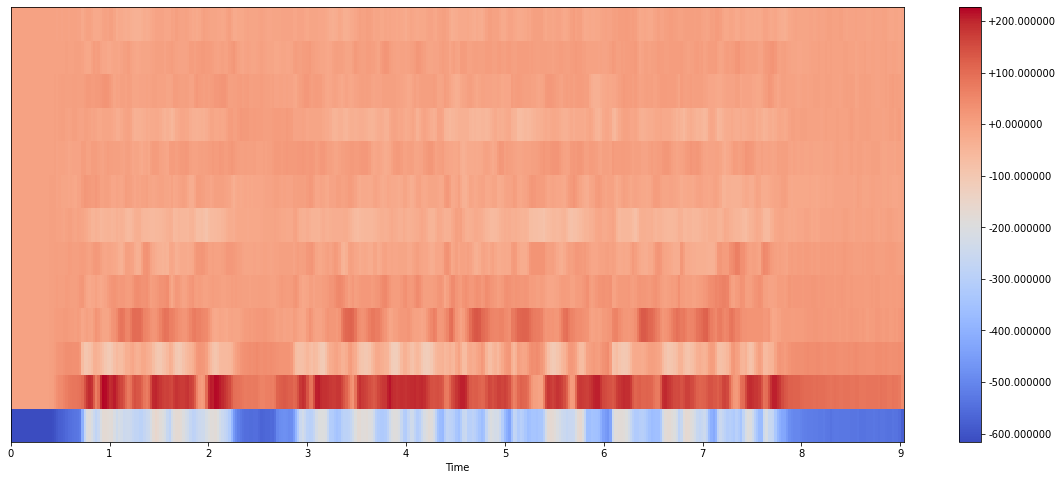

In [22]:
# visualize mfccs
plt.figure(figsize=(20, 8))
librosa.display.specshow(mfccs, x_axis="time", sr=sr)
plt.colorbar(format="%+2f")
plt.show()

In [27]:
# get first order and second order derivatives of mfcc
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

# have the same shape as mfccs
delta_mfccs.shape, delta2_mfccs.shape

((13, 389), (13, 389))

In [29]:
files = os.listdir("/content/data/wavs")
len(files)

1225

## Preprocess

In [35]:
def to_mfcc(audio_path, n_mfcc=13):
    '''
    returns: numpy ndarray
    '''
    signal, sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc, sr=sr)

    return mfccs

In [89]:
# create train, dev, test split

files = os.listdir(os.path.join("/content/data", "wavs"))

files.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(230)
random.shuffle(files) # shuffles the ordering of filenames (deterministic given the chosen seed)

split_1 = int(0.8 * len(files))
split_2 = int(0.9 * len(files))

train_filenames = files[:split_1]
dev_filenames = files[split_1:split_2]
test_filenames = files[split_2:]

In [100]:
def preprocess(root_path, files, partition):

    if not os.path.isdir(f"{root_path}/dataset"):
        os.mkdir(f"{root_path}/dataset/")

    if not os.path.isdir(f"{root_path}/dataset/{partition}"):
        os.mkdir(f"{root_path}/dataset/{partition}")
        os.mkdir(f"{root_path}/dataset/{partition}/mfcc")
        os.mkdir(f"{root_path}/dataset/{partition}/transcript")

    for i, file in enumerate(files):
        audio_path = os.path.join(root_path, "wavs", file)

        basename = os.path.splitext(os.path.basename(audio_path))[0]

        transcript_path = os.path.join(
            root_path, "text",
            basename + ".txt"
        )
        
        mfcc = to_mfcc(audio_path)
        transcript = open(transcript_path).read().replace("\n", " ").upper()

        np.save(f"{root_path}/dataset/{partition}/mfcc/{basename}.npy", mfcc)
        np.save(f"{root_path}/dataset/{partition}/transcript/{basename}.npy", np.array(list(transcript)))

        print(i, partition, basename)

In [103]:
len(train_filenames), len(dev_filenames), len(test_filenames)

(979, 122, 123)

In [ ]:
if os.path.isfile("/content/data/wavs/count.py"):
    os.remove("/content/data/wavs/count.py")

preprocess("/content/data", train_filenames, partition="train")
preprocess("/content/data", dev_filenames, partition="dev")
preprocess("/content/data", test_filenames, partition="test")

In [111]:
# !zip -r dataset.zip "./train" "./test" "./dev".